In [1]:
import os
import numpy as np
from tqdm.auto import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torch.nn as nn
import torch.onnx
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
from torchinfo import summary

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks import LearningRateMonitor

In [2]:
LEARNING_RATE = 2e-5
DEVICE = "cpu"
print("DEVICE: ", DEVICE)
BATCH_SIZE = 32 # 64 in original paper but resource exhausted error otherwise.
WEIGHT_DECAY = 0
EPOCHS = 125
FILES_DIR = '/home/buono/ObjDct_Repo/data/ShipDataset'


DEVICE:  cpu



# Create Loader of Dataset

In [3]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, centers):
        for t in self.transforms:
            img, centers = t(img), centers

        return img, centers


transform = Compose([transforms.Resize((88, 88)), transforms.ToTensor()])

In [4]:
class ShipDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, S=4, B=2, C=1, transform=None, train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C
        self.train = train

        # Determine the directory of the images and labels
        if self.train:
            self.img_dir = os.path.join(self.root_dir, 'images/train')
            self.label_dir = os.path.join(self.root_dir, 'labels/train')
        else:
            self.img_dir = os.path.join(self.root_dir, 'images/test')
            self.label_dir = os.path.join(self.root_dir, 'labels/test')

        self.img_ids = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, index):
        img_id = self.img_ids[index].split('.')[0]
        centers = []
        boxes = []
        # Load image
        img_path = os.path.join(self.img_dir, img_id + '.jpg')
        image = Image.open(img_path)
        image = image.convert("L")

        # Load labels
        label_path = os.path.join(self.label_dir, img_id + '.txt')
        with open(label_path, 'r') as f:
            for line in f.readlines():
                class_label, x, y, width, height = map(float, line.strip().split())
                centers.append([class_label, x, y])
                boxes.append([class_label, x, y, width, height])

        if len(boxes) > 3:
            boxes = boxes[:3]
            centers = centers[:3]

        boxes = torch.tensor(boxes)
        centers = torch.tensor(centers)
        if self.transform:
            image, centers = self.transform(image, centers)
        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 3 * self.B))
        for center in centers:
            class_label, x, y = center
            class_label = int(class_label)
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            if label_matrix[i, j, self.C] == 0:
                label_matrix[i, j, self.C] = 1

                center_coordinates = torch.tensor(
                    [x_cell, y_cell]
                )

                label_matrix[i, j, self.C + 1:self.C + 3] = center_coordinates
                label_matrix[i, j, class_label] = 1

        #print(f"label_matrix shape: {label_matrix.shape}")

        return image, label_matrix , boxes

In [5]:
def collate_fn(batch):
    images = []
    label_matrices = []
    boxes_list = []
    for item in batch:
        images.append(item[0])
        label_matrices.append(item[1])
        boxes_list.append(item[2])
    images = torch.stack(images)
    label_matrices = torch.stack(label_matrices)
    return images, label_matrices, boxes_list


In [6]:
from torch.utils.data import random_split


train_dataset = ShipDataset(
    root_dir=FILES_DIR,
    transform=transform,
    train=True
)


# Define the length of the training set and validation set
train_len = int(0.8 * len(train_dataset))
val_len = len(train_dataset) - train_len

# Split the dataset
train_dataset, validation_dataset = random_split(train_dataset, [train_len, val_len])


# Now you can create your DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, collate_fn=collate_fn)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, collate_fn=collate_fn)


In [7]:
test_dataset = ShipDataset(
    root_dir=FILES_DIR,
    transform=transform,
    train=False
)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, collate_fn=collate_fn)

In [8]:
len(train_dataset), len(validation_dataset), len(test_dataset)

(25426, 6357, 7946)

# Utility Functions

## Euclidean Distance between centers

In [9]:
def euclidean_distance(center_preds, center_labels):
    """
    Calculate euclidean distance
    Parameters:
        center_preds: predictions of centers (BATCH_SIZE, 2)
        center_labels: target of centers of shape (BATCH_SIZE, 2)
    Returns:
        distance: euclidean distance for all examples
    """

    x1 = center_preds[..., 0:1]
    y1 = center_preds[..., 1:2]
    x2 = center_labels[..., 0:1]
    y2 = center_labels[..., 1:2]

    distance = torch.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    return distance

## mAP

In [10]:
def is_center_inside_bbox(center, bbox):
    """
    Check if a center (x, y) is inside a bounding box (x, y, w, h).
    Parameters:
        center (tuple): The (x, y) coordinates of the center.
        bbox (tuple): The (x, y, w, h) coordinates of the bounding box.
    Returns:
        bool: True if the center is inside the bounding box, False otherwise.
    """
    center_x, center_y = center
    bbox_x, bbox_y, bbox_w, bbox_h = bbox

    bbox_x_min = bbox_x - bbox_w / 2
    bbox_x_max = bbox_x + bbox_w / 2
    bbox_y_min = bbox_y - bbox_h / 2
    bbox_y_max = bbox_y + bbox_h / 2

    return bbox_x_min <= center_x <= bbox_x_max and bbox_y_min <= center_y <= bbox_y_max


def mean_average_precision(
    pred_boxes, true_boxes, num_classes=1
):
    """
    Calculates mean average precision
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bbox
        specified as [train_idx, class_prediction, prob_score, x_center, y_center]
        true_boxes (list): Similar as pred_boxes except all the correct ones
        specified as [train_idx, class_label, x, y, w, h]
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes
    """
    average_precisions = []
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            best_match = False

            for idx, gt in enumerate(ground_truth_img):
                if is_center_inside_bbox(detection[3:5], gt[2:]):
                    best_match = True
                    best_gt_idx = idx
                    break

            if best_match:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)



## NMS

In [11]:
def non_max_suppression(centers , threshold = 0.4 , dist_threshold = 0.05):

    assert type(centers) == list
    centers = [center for center in centers if center[1]> threshold]
    centers = sorted(centers, key=lambda x: x[1], reverse=True)
    centers_after_nms = []

    while centers:
        current_center = centers.pop(0)
        centers = [
            center
            for center in centers
            if euclidean_distance(
                torch.tensor(current_center[0]),
                torch.tensor(center[0])
            )
            < dist_threshold
        ]
        centers_after_nms.append(current_center)
        

    return centers_after_nms


## Get and convert centers

In [12]:
def convert_cellcenters(predictions, S=4, C=1):
    """
    Converts predictions from the model to centers
    """
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, S, S, C + 6)

    centers1 = predictions[..., C + 1:C + 3]
    centers2 = predictions[..., C + 4:C + 6]

    scores = torch.cat(
        (predictions[..., C].unsqueeze(0), predictions[..., C + 3].unsqueeze(0)), dim=0
    )
    best_center = scores.argmax(0).unsqueeze(-1)

    best_centers = centers1 * (1 - best_center) + best_center * centers2

    # This results in a tensor with shape (batch_size, 7, 7, 1) where each element represents the index of a grid cell.
    cell_indices = torch.arange(S).repeat(batch_size, S, 1).unsqueeze(-1)
    x = 1 / S * (best_centers[..., :1] + cell_indices)
    # Permute because is used here to swap these indices to match the (x, y) convention used in the best_boxes tensor.
    # [0,1,2]->[0,0,0]
    # [0,1,2]->[1,1,1]
    # [0,1,2]->[2,2,2]
    y = 1 / S * (best_centers[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    converted_centers = torch.cat((x, y), dim=-1)
    predicted_class = predictions[..., :C].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., C], predictions[..., C + 3]).unsqueeze(
        -1
    )

    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_centers), dim=-1
    )

    return converted_preds

In [13]:
def cellcenters_to_centers(out, S=4):
    """
    Converts cell centers to centers
    """
    converted_pred = convert_cellcenters(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_centers = []

    for ex_idx in range(out.shape[0]):
        centers = []
        for center_idx in range(S * S):
            centers.append([x.item() for x in converted_pred[ex_idx, center_idx, :]])
        all_centers.append(centers)

    return all_centers

In [14]:
def get_bboxes(
    loader,
    model,
    device,
):
    all_pred_centers = []
    all_true_centers = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels, boxes_list) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)


        batch_size = x.shape[0]
        true_centers = cellcenters_to_centers(labels) 
        pred_centers = cellcenters_to_centers(predictions) 
        
        for idx in range(batch_size):

            boxes = boxes_list[idx].to(device)

            nms_centers= non_max_suppression(
                pred_centers[idx]
            )

            for center in nms_centers:
                all_pred_centers.append([train_idx] + center)

            for center in true_centers[idx]:
                if center[1] > 0:
                    all_true_centers.append([train_idx] + center)

            for box in boxes:
                all_true_boxes.append([train_idx] + box.tolist())

            train_idx += 1

    return all_pred_centers, all_true_centers, all_true_boxes

## YOLO Loss

In [15]:
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=4, B=2, C=1):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper 20, in dataset 3),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*3) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 3)
        # Calculate distances for the two predicted bounding boxes with target bbox
        dis_c1 = euclidean_distance(predictions[..., self.C + 1:self.C + 3], target[..., self.C + 1:self.C + 3])
        dis_c2 = euclidean_distance(predictions[..., self.C + 4:self.C + 6], target[..., self.C + 1:self.C + 3])
        distances = torch.cat([dis_c1.unsqueeze(0), dis_c2.unsqueeze(0)], dim=0)
        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        dis_maxes, bestcenter = torch.max(distances, dim=0)
        exists_center = target[..., self.C].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR CENTER COORDINATES #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two
        # predictions, which is the one with highest Iou calculated previously.

        center_predictions = exists_center * (
            (
                bestcenter * predictions[..., self.C + 4:self.C + 6]
                + (1 - bestcenter) * predictions[..., self.C + 1:self.C + 3]
            )
        )
        center_targets = exists_center * target[..., self.C + 1:self.C + 3]

        center_loss = self.mse(
            torch.flatten(center_predictions, end_dim=-2),
            torch.flatten(center_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_center = (
            bestcenter * predictions[..., self.C + 3:self.C + 4] + (1 - bestcenter) * predictions[..., self.C:self.C + 1]
        )

        object_loss = self.mse(
            torch.flatten(exists_center * pred_center),
            torch.flatten(exists_center * target[..., self.C:self.C + 1]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        no_object_loss = self.mse(
            torch.flatten((1 - exists_center) * predictions[..., self.C:self.C + 1], start_dim=1),
            torch.flatten((1 - exists_center) * target[..., self.C:self.C + 1], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_center) * predictions[..., self.C + 3:self.C + 4], start_dim=1),
            torch.flatten((1 - exists_center) * target[..., self.C:self.C + 1], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_center * predictions[..., :self.C], end_dim=-2,),
            torch.flatten(exists_center * target[..., :self.C], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * center_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

## Define Model

In [16]:
class LinearActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, t):
        return torch.pow(t, 1) + torch.pow(t,2)

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import ResNet, Bottleneck

class DetNetBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dilation=1):
        super(DetNetBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride,
                               padding=dilation, dilation=dilation, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * 4)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        if stride != 1 or in_channels != out_channels * 4:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * 4),
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class DetNet(nn.Module):
    def __init__(self, layers):
        super(DetNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet stages
        self.layer1 = self._make_layer(Bottleneck, 64, layers[0])
        self.layer2 = self._make_layer(Bottleneck, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(Bottleneck, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(Bottleneck, 512, layers[3], stride=2)

        # DetNet stages
        self.layer5 = self._make_layer(DetNetBottleneck, 256, 3, stride=1, dilation=2)
        self.layer6 = self._make_layer(DetNetBottleneck, 256, 3, stride=1, dilation=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * 4, 1000)

    def _make_layer(self, block, out_channels, blocks, stride=1, dilation=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, dilation))
        self.in_channels = out_channels * 4
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, dilation=dilation))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# Example usage
model = DetNet([3, 4, 6, 3])
print(model)


DetNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): Bottleneck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1),

In [21]:
class DetNetBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dilation=1):
        super(DetNetBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride,
                               padding=dilation, dilation=dilation, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * 4)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        if stride != 1 or in_channels != out_channels * 4:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * 4),
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class DetNetBackbone(nn.Module):
    def __init__(self, layers):
        super(DetNetBackbone, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet stages
        self.layer1 = self._make_layer(Bottleneck, 64, layers[0])
        self.layer2 = self._make_layer(Bottleneck, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(Bottleneck, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(Bottleneck, 512, layers[3], stride=2)

        # DetNet stages
        self.layer5 = self._make_layer(DetNetBottleneck, 256, 3, stride=1, dilation=2)
        self.layer6 = self._make_layer(DetNetBottleneck, 256, 3, stride=1, dilation=2)

    def _make_layer(self, block, out_channels, blocks, stride=1, dilation=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, dilation))
        self.in_channels = out_channels * 4
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, dilation=dilation))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)

        return x

class DetnetFOMO(L.LightningModule):
    def __init__(self, B=2, num_classes=1, S=4):
        super().__init__()
        self.backbone = DetNetBackbone([3, 4, 6, 3])

        self.fclayers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 3 * 3, 256),  # Adjust input size according to output from DetNet
            LinearActivation(),
            nn.Linear(256, S * S * (num_classes + 3 * B)),
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.fclayers(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y, boxes = batch
        out = self(x)
        loss = self.loss_fn(out, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y, boxes = batch
        out = self(x)
        loss = self.loss_fn(out, y)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

model = DetnetFOMO()
summary(model, input_size=(1, 1, 256, 256))


RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Conv2d: 2, BatchNorm2d: 2, ReLU: 2, MaxPool2d: 2, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Conv2d: 4, BatchNorm2d: 4]

# Training

In [22]:
loss_fn = YoloLoss()

checkpoint_callback = ModelCheckpoint(save_top_k=1, 
                                      monitor="val_loss", 
                                      mode="min")
lr_monitor_callback = LearningRateMonitor(logging_interval='epoch')

trainer = L.Trainer(accelerator=DEVICE, 
                    callbacks=[checkpoint_callback, lr_monitor_callback], 
                    max_epochs=EPOCHS, 
                    enable_progress_bar=True, 
                    enable_model_summary=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/buono/ObjDct_Repo/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [24]:
os.makedirs("lightning_logs", exist_ok=True)

In [26]:
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)


  | Name     | Type       | Params | Mode 
------------------------------------------------
0 | loss_fn  | YoloLoss   | 0      | train
1 | layer1   | Sequential | 104    | train
2 | layer2   | Sequential | 1.2 K  | train
3 | fclayers | Sequential | 78.2 K | train
------------------------------------------------
79.5 K    Trainable params
0         Non-trainable params
79.5 K    Total params
0.318     Total estimated model params size (MB)


Sanity Checking: |          | 1/? [00:00<00:00,  2.23it/s]

/home/buono/ObjDct_Repo/venv/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


/home/buono/ObjDct_Repo/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 1:   0%|          | 0/795 [00:00<?, ?it/s, v_num=0]          

/home/buono/ObjDct_Repo/venv/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 21. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 8:  54%|█████▍    | 433/795 [03:11<02:40,  2.26it/s, v_num=0]

/home/buono/ObjDct_Repo/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
model.eval()
with torch.no_grad():
    pred_centers, target_centers, real_boxes = get_bboxes(
        test_loader, model, DEVICE
    )
    mAP = mean_average_precision(pred_centers, real_boxes)
    print(f"mAP: {mAP}")
torch.save(model.state_dict(), "../../models/trained_models/LeNetFOMO.pth")

## Plot test results and statistics

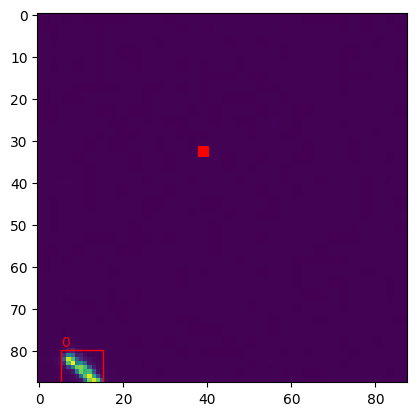

In [22]:
def plot_centers(idx, pred_centers, target_centers):
    values = test_dataset[idx]
    image = values[0]
    image = image.permute(1, 2, 0).to("cpu")

    image = np.array(image)
    height, width, _ = image.shape
    p_centers = []
    t_centers = []
    for center in pred_centers:
        if center[0] == idx:
            p_centers.append(center[1:])

    for center in target_centers:
        if center[0] == idx:
            t_centers.append(center[1:])


    fig, ax = plt.subplots()
    ax.imshow(image)
    for center in p_centers:
        rect = patches.Rectangle(
            (center[2] * width , center[3] * height),
            1,
            1,
            linewidth=5,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)
    # Create a Rectangle patch
    for boxes in t_centers:
        class_label = int(boxes[0])
        box = boxes[1:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

        # Add class label text
        ax.text(upper_left_x * width, upper_left_y * height, str(class_label), color='r', fontsize=10, verticalalignment='bottom')


    plt.show()

plot_centers(0, pred_centers, target_centers)